# Training of the ProGAN - Example

### imports:

In [1]:
import os
import sys
import yaml
sys.path.append('../../')

import torch
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning import Trainer, loggers
from torch.utils.data import DataLoader, random_split


from syndatagenerators.models.progressive_gan.trainer import TrainerProGAN
from syndatagenerators.data_preparation.datasets import LondonDataset, SineDataset
from syndatagenerators.models.utils.callbacks import MMDCallback, ACFCallback, DiscriminativeCallback

### Load configuration file with data, train and network parameters

### define path to train data directory, checkpoint directory, config file, and number of households to use

In [2]:
# define directory where train data is saved
TRAIN_DATA_DIR = '../train_data'
#TRAIN_DATA_DIR = "/share/data1/mjuergens/SyLasKI/data/Small_LCL_Data/"
# directory where model is saved/loaded from
#CKPT_DIR = '../ckpt/'
CKPT_DIR = '/share/data1/bschaefermeier/chkpt/progan/'
# path to configuration file
CONFIG_PATH = '../models/utils/config_progan2.yml'
# number of households
N_HOUSEHOLDS = 1000 # needs to be in range(1, n_ids) --> check n_ids

### load parameters, create list of household ID's

In [3]:
config = yaml.safe_load(open(CONFIG_PATH, 'r'))
data_params = config['data_params']
train_params = config['train_params']
gen_params = config['gen_params']
dis_params = config['dis_params']

list_assets = ['MAC' + str(i).zfill(6) for i in range(2, 100)] # Use 100 Different households
list_assets = ['MAC' + str(i).zfill(6) for i in range(2, 1000)] # Use 1000 Different households

In [4]:
config

{'train_params': {'batch_size': 64,
  'lr': 1e-05,
  'epochs': 3500,
  'sample_cycle': 10,
  'lambda_gp': 10,
  'n_critic': 5,
  'epochs_per_step': 5,
  'nb_fade_in_epochs': 150,
  'schedule': [800, 1500, 2100, 2600],
  'name': 13,
  'feature_dim': 1,
  'target_len': 128,
  'nb_labels': 1},
 'dis_params': {'kernel_size': 11, 'channel_dim': 32},
 'gen_params': {'kernel_size': 11, 'channel_dim': 32},
 'data_params': {'window_len': 64,
  'overlap': 0,
  'n_households': 1000,
  'train_data_dir': '/share/data1/mjuergens/SyLasKI/train_data',
  'ckpt_dir': '/share/data1/bschaefermeier/chkpt/progan/'}}

### initialize the model and the London Smart Meter Dataset

In [5]:
model = TrainerProGAN(train_params=train_params, dis_params=dis_params, gen_params=gen_params)

# dataset: takes some time to initialize if train data has not been loaded before
dataset = LondonDataset(assets=list_assets, window_length=config['data_params']['window_len'],
                            overlap=config['data_params']['overlap'], train_data_dir=TRAIN_DATA_DIR,
                            labels=False)
#dataset = SineDataset()
len(dataset)

231865

### split in training and validation: for the moment, randomly, this would need to be adjusted


In [6]:
# split into train and validation set
trainsize = int(0.9*len(dataset))
valsize = len(dataset) - trainsize
dataset_train, dataset_val = random_split(dataset, [trainsize, valsize])

# dataloaders for training and validation
loader_train = DataLoader(dataset_train, batch_size=config['train_params']['batch_size'], shuffle=False,
                          num_workers=8)
loader_val = DataLoader(dataset_val, batch_size=len(dataset_val), shuffle=False)

print(f'Training size: {len(dataset_train)} Validation size: {len(dataset_val)}')

Training size: 208678 Validation size: 23187


### Callbacks to be used during training

In [7]:
FILENAME = f'{model.__class__.__name__}_{model.name}'
MODEL_PATH = os.path.join(CKPT_DIR, str(train_params['name']))

# callback that calculates MMD every ith epoch
mmd_callback = MMDCallback(size=1000)

# callback that calculates discriminative score using an LSTM
discriminative_callback = DiscriminativeCallback(size=1000)

# callback for early stopping using MMD
#early_stopping_callback = EarlyStopping('mmd', patience=4)
early_stopping_callback = EarlyStopping('generator loss', patience=30, stopping_threshold=-5)

# checkpoint callback
checkpoint_callback = ModelCheckpoint(dirpath=CKPT_DIR, filename=FILENAME, every_n_epochs=10, save_top_k=1, monitor="generator loss")

## Initialize Lightning Trainer and Tensorboard Logger

In [8]:
# tensorboard logger
tb_logger = pl.loggers.TensorBoardLogger(save_dir=MODEL_PATH)

#callbacks = [mmd_callback, checkpoint_callback, early_stopping_callback]
#callbacks = [checkpoint_callback, early_stopping_callback]
callbacks = [mmd_callback, checkpoint_callback]
trainer = pl.Trainer(logger=tb_logger, accelerator='cuda', max_epochs=config['train_params']['epochs'],
                     callbacks=callbacks,
                     check_val_every_n_epoch=5)
# Precision=16 should speed up training by using half-precision floating numbers where possible. In practice, this resulted in being slower.
# See https://devblog.pytorchlightning.ai/how-we-used-pytorch-lightning-to-make-our-deep-learning-pipeline-10x-faster-731bd7ad318a

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Train the model

In [9]:
import time
start_time = time.time()
trainer.fit(model, loader_train, loader_val)
duration = time.time()-start_time
print(f"Training for {trainer.current_epoch} epochs took {duration}seconds.")

/home/bschaefermeier/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/configuration_validator.py:211: LightningDeprecationWarning: The `LightningModule.on_epoch_end` hook was deprecated in v1.6 and will be removed in v1.8. Please use `LightningModule.on_<train/validation/test>_epoch_end` instead.
  f"The `LightningModule.{hook}` hook was deprecated in v1.6 and"
/home/bschaefermeier/.local/lib/python3.7/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /share/data1/bschaefermeier/chkpt/progan exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name          | Type         | Params
-----------------------------------------------
0 | loss          | WGANGPLoss   | 0     
1 | generator     | ProGenerator | 95.7 K
2 | discriminator | ProCritic    | 113 K 
-----------------------------------------------
209 K     Trainable params
0   

Sanity Checking: 0it [00:00, ?it/s]

/home/bschaefermeier/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:241: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 128 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Training for 0 epochs took 24.57504963874817seconds.


/home/bschaefermeier/.local/lib/python3.7/site-packages/pytorch_lightning/trainer/trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


In [ ]:
checkpoint_callback.best_model_score

## Reload Checkpoint
Optionally, load checkpoint and run the notebook starting from here (need to execute cells with imports first, of course!).

In [7]:
def load_checkpoint(path):
    model = TrainerProGAN.load_from_checkpoint(path)
    model.eval()
    return model

LOAD_CHECKPOINT = True
# Checkpoint for first model that was trained with 1000 households instead of 100.
if LOAD_CHECKPOINT:
    chkpt = '/share/data1/bschaefermeier/chkpt/progan/TrainerProGAN_12-v39.ckpt'
    chkpt = '/share/data1/bschaefermeier/chkpt/progan/TrainerProGAN_12-v40.ckpt'
    model = load_checkpoint(chkpt)

## Generate synthetic data

In [8]:
def generate_synthetic_samples(generator, depth: int = 4, size: int = 5000,
                               clip: bool = True):
    generator.eval()
    z = torch.randn(size, generator.nb_features, generator.target_len).float()
    x_gen = generator(z, depth=depth, residual=0).detach()
    x_gen = generator(z, depth=depth, residual=False).detach()

    if clip:
        x_gen = torch.clamp(x_gen, 0, 1)
    return x_gen

In [20]:
x_gen = generate_synthetic_samples(model.generator, depth=4, clip=False)
x_gen.shape

torch.Size([5000, 1, 128])

## Evaluate the model
Plot samples, TSNE and calculate MMD.

In [16]:
from syndatagenerators.metrics.visualization import plot_TSNE
from syndatagenerators.models.utils.plot_functions import plot_sample_grid

../../syndatagenerators/models/utils/plot_functions.py:80: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  sample = np.random.choice([x for x in data], n_rows*n_cols) if random_sample else data[:n_rows*n_cols]
../../syndatagenerators/models/utils/plot_functions.py:80: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sample = np.random.choice([x for x in data], n_rows*n_c

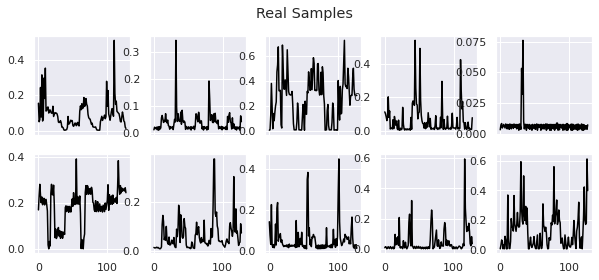

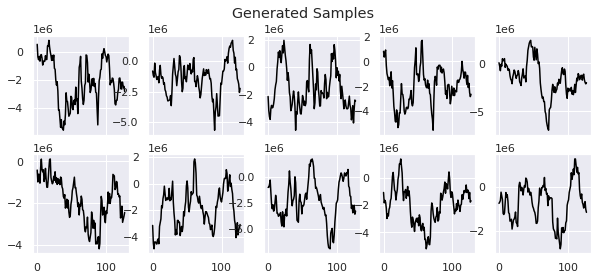

In [21]:
real_plot = plot_sample_grid(dataset.data, random_sample=True, title='Real Samples')
gen_plot = plot_sample_grid(x_gen, random_sample=True, title='Generated Samples')

/home/bschaefermeier/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/bschaefermeier/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


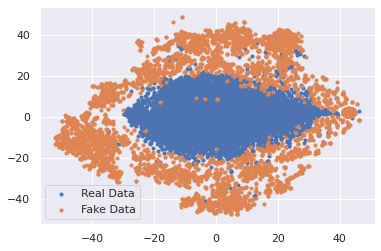

In [18]:
tsne_plot = plot_TSNE(dataset_val[:5000], x_gen, use_seaborn=True)

In [19]:
from syndatagenerators.metrics.mmd_score import mmd
mmd(dataset_val[:], x_gen)

tensor(0.2409)